In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


In [ ]:
file_path = "../data/cleaned/IMDB_movies.csv"
df = pd.read_csv(file_path)

# Câu 1

Dựa trên các đặc trưng `vote_count`, `rating` và `metascore`, các bộ phim có thể được phân thành những nhóm phổ biến – chất lượng đặc trưng nào, và đặc điểm của từng nhóm là gì? Tệp khán giả chủ yếu của mỗi nhóm phim đó là gì thông qua đặc trưng `mpa`?

- **Động lực**:
    - Trong ngành công nghiệp phim ảnh, mức độ phổ biến (nhiều người xem) và chất lượng (được đánh giá cao) không phải lúc nào cũng trùng nhau. Một bộ phim có thể:
        - Rất phổ biến nhưng bị đánh giá thấp

        - Ít phổ biến nhưng được giới phê bình đánh giá cao

     Câu hỏi này giúp làm rõ cấu trúc ẩn của mối quan hệ đó

- **Lợi ích**: Câu hỏi này giúp xác định:
    - Có bao nhiêu nhóm phim phổ biến – chất lượng đặc trưng. VD:
        - Nhóm phim rating cao – metascore cao nhưng vote thấp → phim nghệ thuật

        - Nhóm phim vote cao – rating trung bình → phim thương mại đại chúng

    - Insight về tệp khán giả, Thông qua MPA (G, PG, PG-13, R, NC-17), ta có thể suy luận:

        - Nhóm phim hướng tới gia đình

        - Nhóm phim dành cho thanh thiếu niên

        - Nhóm phim dành cho người trưởng thành


- **Những bên quan tâm**:

    - Nhà sản xuất phim

        - Phim của mình thuộc nhóm nào

        - Có đang nhắm đúng tệp khán giả không

    - Nền tảng streaming (Netflix, Disney+, v.v.)

        - Phân loại nội dung
        - Gợi ý phim theo nhóm khán giả

    - Nhà phân tích dữ liệu & nghiên cứu

        - Nghiên cứu hành vi khán giả

        - Phân tích thị trường giải trí

    - Bộ phận marketing, giúp uyết định:

        - Chiến lược quảng bá

        - Phân khúc khán giả mục tiêu

## 1.1 Tiền xử lí

### Chuẩn bị dữ liệu & chuẩn hóa

In [32]:

# Các biến dùng để phân nhóm: mức độ phổ biến & chất lượng
features = ["vote_count", "rating", "metascore"]

# Loại bỏ các dòng thiếu dữ liệu ở các cột quan trọng
df_cluster = df[features + ["mpa"]].dropna()

# Chuẩn hóa dữ liệu để các biến có cùng thang đo
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster[features])


## 1.2 Phân tích

### Elbow Method – xác định số nhóm K

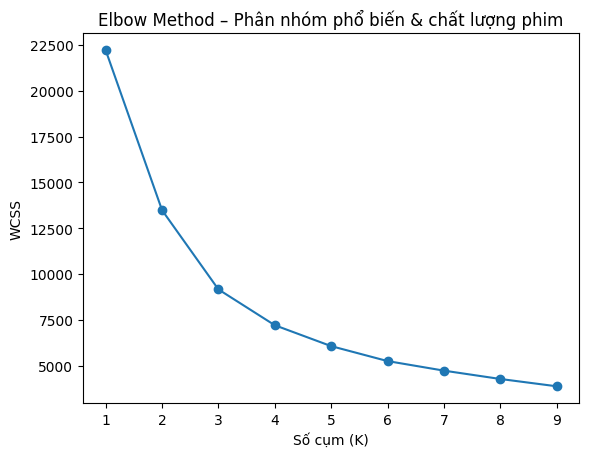

In [33]:

wcss = []

# Thử nhiều giá trị K để quan sát cấu trúc dữ liệu
for k in range(1, 10):
    kmeans = KMeans(
        n_clusters=k,
        init="k-means++",   # Giúp hội tụ nhanh và ổn định hơn
        random_state=42
    )
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)  # WCSS: độ chặt của các cụm

# Vẽ biểu đồ Elbow
plt.figure()
plt.plot(range(1, 10), wcss, marker="o")
plt.xlabel("Số cụm (K)")
plt.ylabel("WCSS")
plt.title("Elbow Method – Phân nhóm phổ biến & chất lượng phim")
plt.show()


Dựa trên biểu đồ Elbow Method, WCSS giảm mạnh khi K tăng từ 1 đến 3 và bắt đầu giảm chậm hơn đáng kể từ K ≥ 3. Điều này cho thấy K = 3 là số cụm hợp lý (điểm 'gãy'), vừa phản ánh cấu trúc dữ liệu 3 biến, vừa đảm bảo khả năng diễn giải.

In [34]:
# Huấn luyện K-Means với K = 3
kmeans = KMeans(n_clusters=3, random_state=42)

# Gán nhãn cụm cho từng phim
df_cluster["Cluster"] = kmeans.fit_predict(X_scaled)

# Phân tích đặc trưng trung bình của từng nhóm
cluster_profile = df_cluster.groupby("Cluster")[features].mean()

print(cluster_profile)

            vote_count    rating  metascore
Cluster                                    
0         79601.824257  5.932178  44.760210
1        104083.832982  7.164512  71.519525
2        850350.000000  7.849737  74.068421


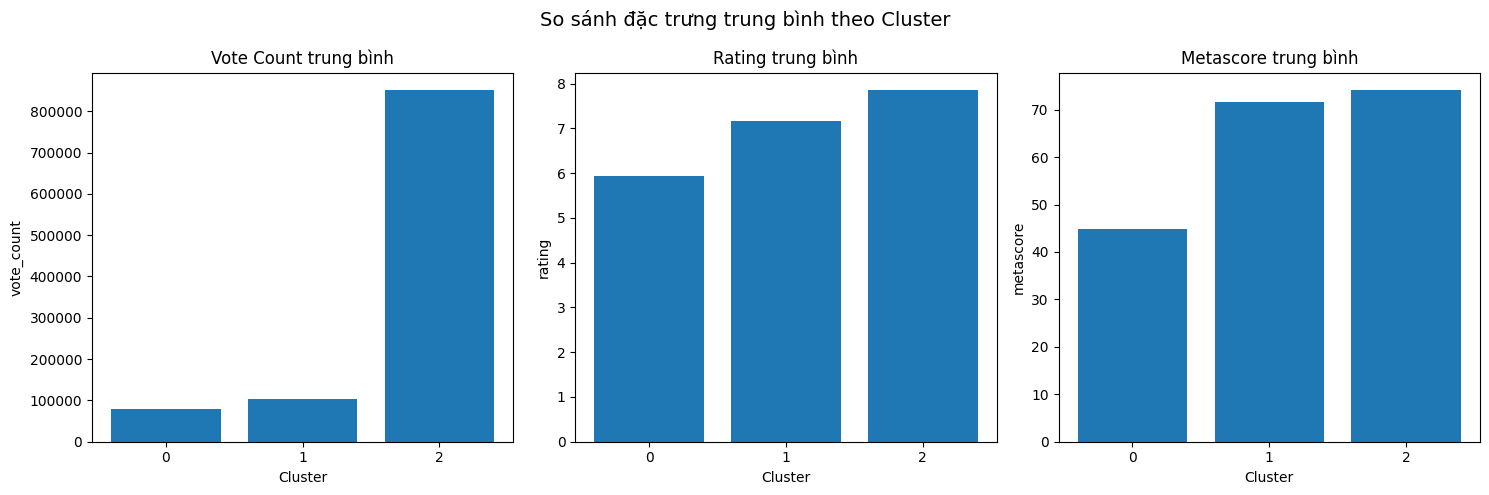

In [35]:

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)
clusters = cluster_profile.index  # [0, 1, 2]

# vote_count
axes[0].bar(cluster_profile.index, cluster_profile["vote_count"])
axes[0].set_title("Vote Count trung bình")
axes[0].set_xlabel("Cluster")
axes[0].set_ylabel("vote_count")
axes[0].set_xticks(clusters)  

# rating
axes[1].bar(cluster_profile.index, cluster_profile["rating"])
axes[1].set_title("Rating trung bình")
axes[1].set_xlabel("Cluster")
axes[1].set_ylabel("rating")

# metascore
axes[2].bar(cluster_profile.index, cluster_profile["metascore"])
axes[2].set_title("Metascore trung bình")
axes[2].set_xlabel("Cluster")
axes[2].set_ylabel("metascore")

plt.suptitle("So sánh đặc trưng trung bình theo Cluster", fontsize=14)
plt.tight_layout()
plt.show()



Dựa trên kết quả phân cụm với K = 3 sử dụng các đặc trưng vote_count, IMDb rating và metascore, các bộ phim trong tập dữ liệu được phân thành ba nhóm có đặc điểm rõ rệt về mức độ phổ biến và chất lượng đánh giá.

**Cụm 0 – Phim ít phổ biến, chất lượng trung bình–thấp**: Có số lượt bình chọn trung bình thấp nhất (vote_count ≈ 79.602), đồng thời điểm đánh giá (rating ≈ 5.93) và điểm phê bình (metascore ≈ 44.76) cũng ở mức thấp. Nhóm phim này nhìn chung có mức độ phổ biến hạn chế và chất lượng chưa được đánh giá cao, có thể bao gồm các phim kém thu hút khán giả đại chúng hoặc thuộc các phân khúc thị trường ngách với mức độ hấp dẫn thấp.

**Cụm 1 – Phim phổ biến vừa phải, chất lượng tốt**: Có số lượt bình chọn trung bình (vote_count ≈ 104.084) cao hơn cụm 0, đi kèm với điểm đánh giá người xem (rating ≈ 7.16) và điểm phê bình (metascore ≈ 71.52) ở mức khá cao. Điều này cho thấy đây là nhóm phim vừa đạt được mức độ phổ biến tương đối, vừa được đánh giá tích cực cả từ khán giả lẫn giới phê bình, phản ánh sự cân bằng giữa yếu tố thương mại và chất lượng nội dung.

**Cụm 2 – Phim rất phổ biến, chất lượng cao**: Nổi bật với số lượt bình chọn trung bình vượt trội (vote_count ≈ 850.350), cao hơn đáng kể so với hai cụm còn lại. Đồng thời, cụm này cũng đạt điểm đánh giá cao nhất về cả rating (≈ 7.85) và metascore (≈ 74.07). Đây là nhóm các phim có sức hút lớn đối với khán giả đại chúng và được đánh giá cao về mặt chất lượng, thường bao gồm các tác phẩm thành công cả về mặt thương mại lẫn chuyên môn.

### Phân tích tệp khán giả thông qua MPA

In [36]:
# Đếm số lượng phim theo Cluster và MPA
mpa_count = (
    df_cluster
    .groupby(["Cluster", "mpa"])
    .size()
    .reset_index(name="count")
)

# Tính tổng số phim trong mỗi Cluster
cluster_total = (
    df_cluster
    .groupby("Cluster")
    .size()
    .reset_index(name="total")
)

# Gộp để tính tỷ lệ
mpa_summary = mpa_count.merge(cluster_total, on="Cluster")

# Tính tỷ lệ %
mpa_summary["percentage"] = (
    mpa_summary["count"] / mpa_summary["total"]
)

print(mpa_summary)


    Cluster        mpa  count  total  percentage
0         0   Approved      6   3232    0.001856
1         0          G     33   3232    0.010210
2         0         GP      2   3232    0.000619
3         0      NC-17      9   3232    0.002785
4         0  Not Rated    114   3232    0.035272
5         0         PG    440   3232    0.136139
6         0      PG-13   1039   3232    0.321473
7         0     Passed      1   3232    0.000309
8         0          R   1452   3232    0.449257
9         0      TV-14     27   3232    0.008354
10        0       TV-G      1   3232    0.000309
11        0      TV-MA     75   3232    0.023205
12        0      TV-PG      5   3232    0.001547
13        0      TV-Y7      1   3232    0.000309
14        0    Unrated     26   3232    0.008045
15        0          X      1   3232    0.000309
16        1        13+      2   3790    0.000528
17        1        16+      2   3790    0.000528
18        1        18+      1   3790    0.000264
19        1   Approv

In [37]:
df_cluster["mpa"].unique()

array(['R', 'PG-13', 'PG', 'Approved', 'G', 'Not Rated', 'TV-MA', 'NC-17',
       'Unrated', 'TV-14', 'M/PG', 'TV-PG', '13+', 'GP', '16+', 'M',
       'Passed', 'TV-Y7', 'TV-G', 'X', '18+', 'MA-17'], dtype=object)

Do dữ liệu sử dụng nhiều hệ thống phân loại độ tuổi khác nhau (MPA, TV rating, hệ thống cũ), các nhãn MPA được gom lại thành các nhóm độ tuổi tương đối nhằm giảm số lượng danh mục và tăng khả năng diễn giải. Việc gom nhóm này không nhằm phản ánh chính xác tuyệt đối hệ thống kiểm duyệt, mà nhằm phục vụ phân tích hành vi khán giả và phạm vi tiếp cận nội dung ở mức khái quát

### Gộp MPA thành nhóm tuổi tổng quát

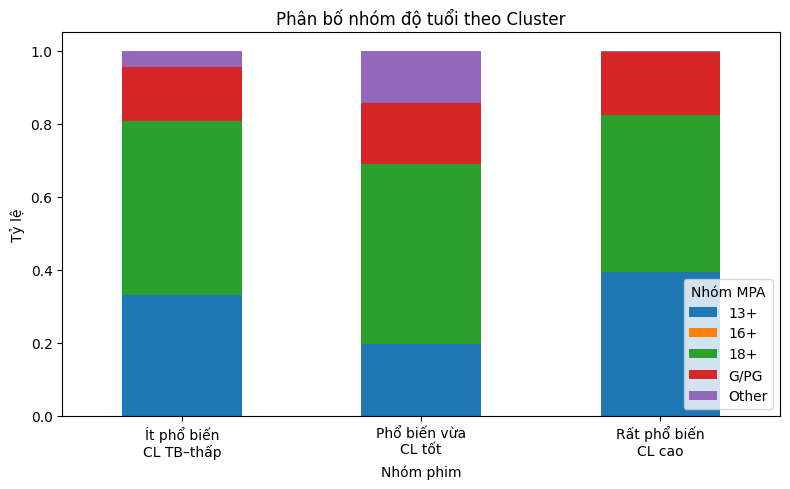

In [38]:
#  Gộp MPA thành nhóm độ tuổi chính
mpa_map = {
    # Mọi lứa tuổi
    "G": "G/PG", "PG": "G/PG", "GP": "G/PG",
    "TV-G": "G/PG", "TV-Y7": "G/PG",

    # 13+
    "PG-13": "13+", "13+": "13+",
    "TV-14": "13+", "TV-PG": "13+",

    # 16+
    "16+": "16+", "M/PG": "16+", "M": "16+",

    # 18+
    "R": "18+", "NC-17": "18+", "MA-17": "18+",
    "18+": "18+", "TV-MA": "18+", "X": "18+",

    # Không xếp hạng / cũ
    "Approved": "Other", "Passed": "Other",
    "Not Rated": "Other", "Unrated": "Other"
}

df_cluster["mpa_group"] = df_cluster["mpa"].map(mpa_map).fillna("Other")

# Tính phân bố tỷ lệ MPA theo từng cluster 
mpa_group_dist = (
    df_cluster
    .groupby(["Cluster", "mpa_group"])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum())
    .unstack()
)

# Vẽ biểu đồ
ax = mpa_group_dist.plot(
    kind="bar",
    stacked=True,
    figsize=(8, 5)
)

ax.set_title("Phân bố nhóm độ tuổi theo Cluster")
ax.set_ylabel("Tỷ lệ")
ax.set_xlabel("Nhóm phim")

cluster_labels = [
    "Ít phổ biến\nCL TB–thấp",
    "Phổ biến vừa\nCL tốt",
    "Rất phổ biến\nCL cao"
]

ax.set_xticks(range(len(cluster_labels)))
ax.set_xticklabels(cluster_labels, rotation=0)

ax.legend(title="Nhóm MPA")
plt.tight_layout()
plt.show()


Biểu đồ cho thấy sự khác biệt rõ rệt về phân bố nhóm độ tuổi (MPA) giữa các nhóm phim.

**Cụm 0 – Phim ít phổ biến, chất lượng trung bình–thấp**: có tỷ lệ phim dành cho đối tượng trưởng thành (18+) chiếm ưu thế, bên cạnh đó vẫn tồn tại một tỷ lệ đáng kể phim thuộc nhóm 13+, cho thấy nội dung của nhóm này tương đối đa dạng nhưng chưa tạo được sức hút lớn đối với khán giả đại chúng.

**Cụm 1 – Phim phổ biến vừa phải, chất lượng tốt**: tiếp tục duy trì tỷ lệ cao các phim 18+, đồng thời có sự gia tăng nhẹ của nhóm G/PG và Other, phản ánh sự cân bằng hơn về đối tượng khán giả cũng như xu hướng nội dung phù hợp với nhiều nhóm tuổi hơn.

Trong khi đó, **Cụm 2 – Phim rất phổ biến, chất lượng cao**: nổi bật với tỷ lệ phim 13+ cao nhất so với các cụm còn lại, cùng với tỷ lệ phim 18+ vẫn chiếm phần lớn. Điều này cho thấy các phim thành công nhất thường hướng tới nhóm khán giả rộng hơn, đặc biệt là thanh thiếu niên và người trưởng thành, qua đó tối đa hóa khả năng tiếp cận và mức độ phổ biến.

### Nhận xét tổng quát và hạn chế

Nghiên cứu đã áp dụng các phương pháp học không giám sát (Unsupervised Learning) để phân loại phim dựa trên mức độ phổ biến và chất lượng đánh giá, thông qua các đặc trưng `vote_count`, `rating` và `metascore`. Kết quả phân cụm cho thấy dữ liệu phim không phân bố đồng nhất mà tồn tại các nhóm đặc trưng rõ rệt, phản ánh những phân khúc khác nhau của thị trường phim. Cụ thể, ba nhóm phim được xác định tương ứng với:

- Nhóm phim ít phổ biến, chất lượng trung bình–thấp,

- Nhóm phim phổ biến vừa phải, chất lượng tốt,

- Nhóm phim rất phổ biến, chất lượng cao.

Bên cạnh đó, phân tích phân bố nhóm độ tuổi (MPA) cho thấy các phim thuộc nhóm 13+ và 18+ chiếm tỷ trọng lớn ở tất cả các cụm, đặc biệt là trong các cụm phim phổ biến. Điều này cho thấy các phim hướng tới nhóm khán giả thanh thiếu niên và người trưởng thành có xu hướng đạt mức độ tiếp cận và phổ biến cao hơn.

### Hạn chế

Mặc dù mang lại nhiều insight hữu ích, nghiên cứu vẫn tồn tại một số hạn chế nhất định:

- Thứ nhất, việc phân cụm dựa trên số lượng hạn chế các đặc trưng định lượng (vote_count, rating, metascore) có thể chưa phản ánh đầy đủ toàn bộ yếu tố ảnh hưởng đến mức độ phổ biến và chất lượng phim. Các yếu tố khác như thể loại phim, ngân sách sản xuất, thời điểm phát hành hoặc chiến lược marketing chưa được xem xét.

- Thứ hai, số lượng cụm được lựa chọn dựa trên Elbow Method kết hợp với khả năng diễn giải thực tiễn. Tuy nhiên, Elbow Method mang tính chất tham khảo và việc lựa chọn số cụm có thể thay đổi nếu sử dụng các tiêu chí khác hoặc mục tiêu phân tích khác.

- Thứ ba, việc gom các nhãn phân loại độ tuổi (MPA) thành các nhóm tuổi chính mang tính xấp xỉ và được thực hiện nhằm mục đích phân tích khái quát.
